# What makes a good predictor of home prices?

In [1]:
# Import statements
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as scs
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
plt.style.use('seaborn-colorblind')
%matplotlib inline

In [2]:
# Read in cleaned Kings County file 
df = pd.read_csv("cleaned_kings.csv")
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'])
df.head()

,Unnamed: 0.1.1,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,01/01/1970,221900.0,3,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,01/01/1970,538000.0,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,01/01/1970,180000.0,2,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,01/01/1970,604000.0,4,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,01/01/1970,510000.0,3,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [3]:
df = df.drop(columns='Unnamed: 0.1.1')

## Evaluate outliers
It seems there are very few highly priced homes that would negatively impact a prediction model. Let's take out the top priced homes for a representative model. According to the box plot below we have significant outliers.

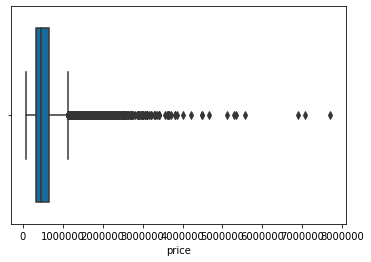

In [4]:
# Create boxplot for price
sns.boxplot(x='price', data=df);

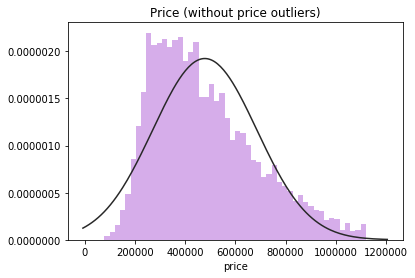

20268 21420
Number of homes excluded is 1152
Reduced homes by 5%


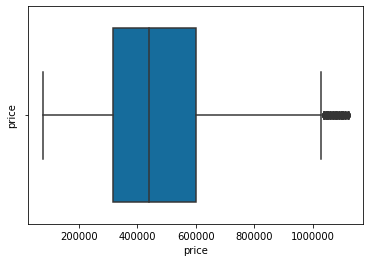

In [5]:
# Calculate the price limit for outliers using 1.5 * IQR + Q3
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
limit = 1.5 * IQR + Q3
limit

# Remove upper outliers from sqft_lot and create histogram again
df_price = df[df['price'] < limit]

# Histogram (distplot)
sns.distplot(df_price['price'], color='darkorchid', label=df_price, fit=norm, kde=False)
plt.title('Price (without price outliers)')
plt.show()
print(len(df_price), len(df))
print('Number of homes excluded is ' + str(len(df) - len(df_price)))
print('Reduced homes by ' + str(round(100 - len(df_price) / len(df) * 100)) + '%')

sns.scatterplot(x="zipcode", y="price", data=df_price)
sns.boxplot(x='price', data=df_price);

The histogram and box plot above show a more normal set of data values for us to evaluate. Let's now use pairwise plots between our given conditions and price to see if there are any linear relationships to explore.

## A check for linear relationships

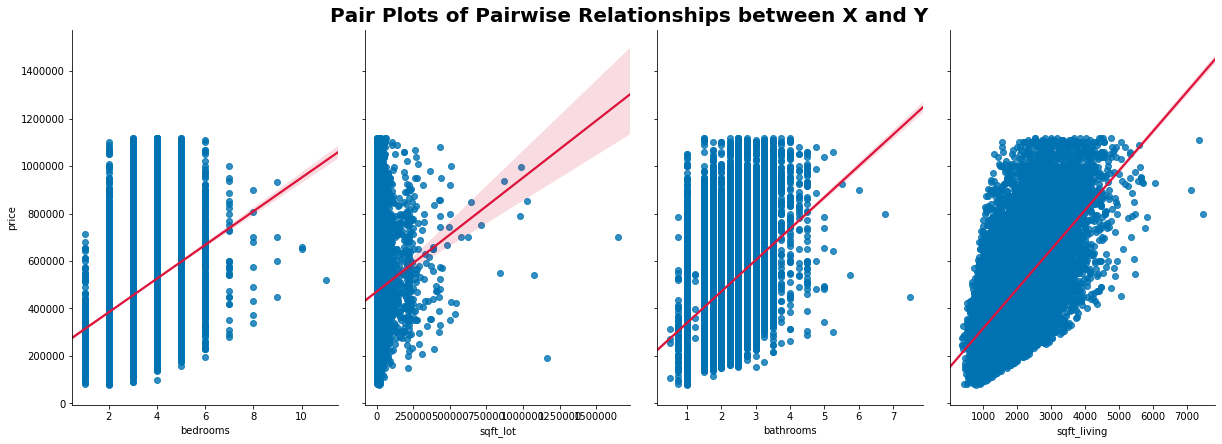

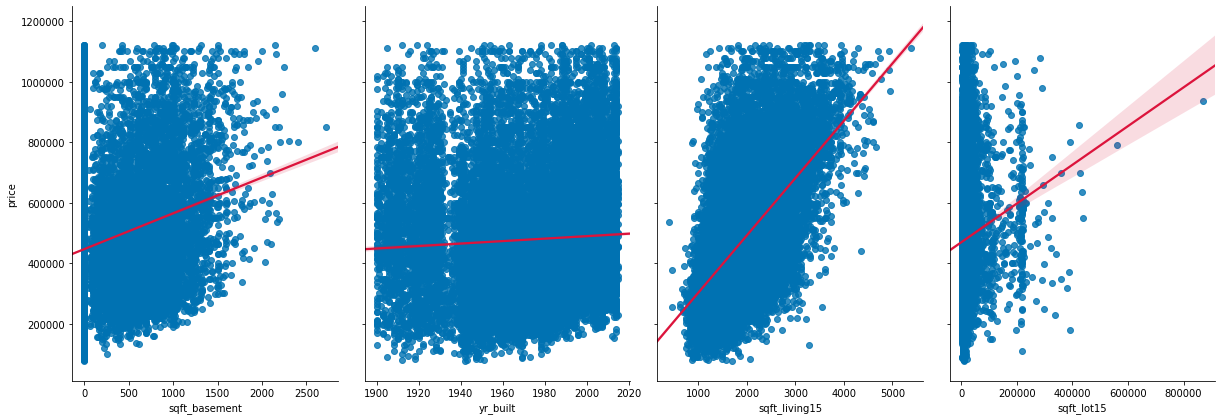

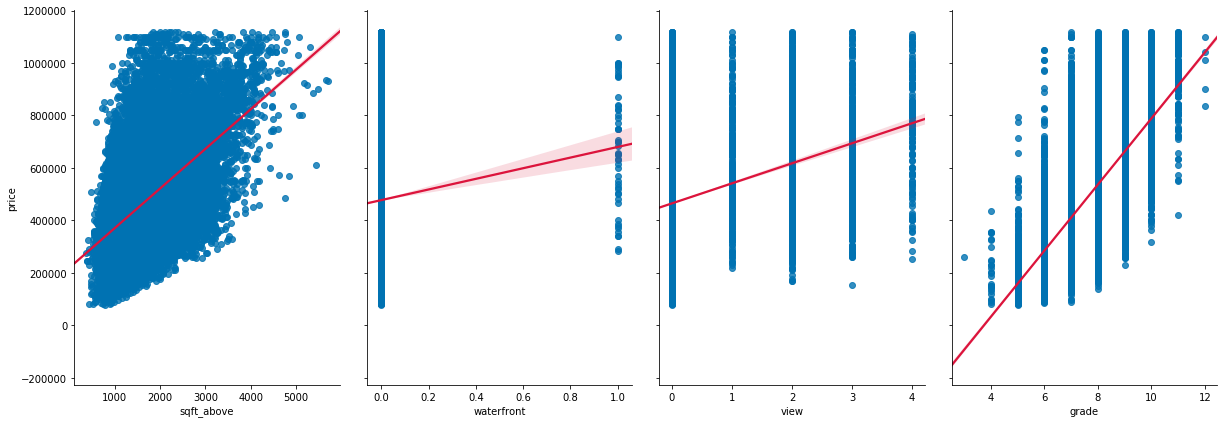

In [6]:
# visualize the pairwise relationship between the features and the response using pairplots 

sns.pairplot(x_vars=['bedrooms', 'sqft_lot', 'bathrooms', 'sqft_living'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)

plt.suptitle('Pair Plots of Pairwise Relationships between X and Y', size=20, weight='bold', y=1.02)

sns.pairplot(x_vars=['sqft_basement', 'yr_built', 'sqft_living15', 'sqft_lot15'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)
sns.pairplot(x_vars=['sqft_above', 'waterfront', 'view', 'grade'], y_vars='price', data=df_price, 
             kind='reg', plot_kws={'line_kws':{'color':'crimson'}}, height=6, aspect=0.7)
plt.show();

A few of the graphs seem to have a good linear relationship: bedrooms, bathrooms, sqft_living, sqft_living15, sqft_above, and grade. After checking for normalcy, let's evaluate these relationships.

## A check for normalcy

In [7]:
# First well limit our set to the indicated features
data = df_price[['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_living15', 'sqft_above', 'grade']]


In [8]:
data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_living15,sqft_above,grade
0,221900.0,3,1.00,1180,1340,1180,7
1,538000.0,3,2.25,2570,1690,2170,7
2,180000.0,2,1.00,770,2720,770,6
3,604000.0,4,3.00,1960,1360,1050,7
4,510000.0,3,2.00,1680,1800,1680,8


Text(0.5, 1.0, 'price')

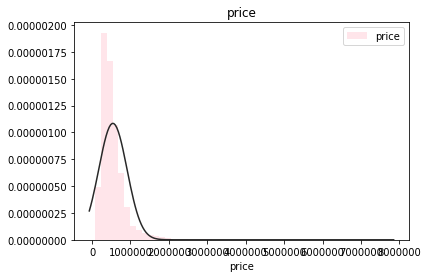

Text(0.5, 1.0, 'bedrooms')

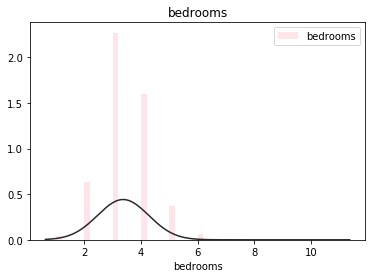

Text(0.5, 1.0, 'bathrooms')

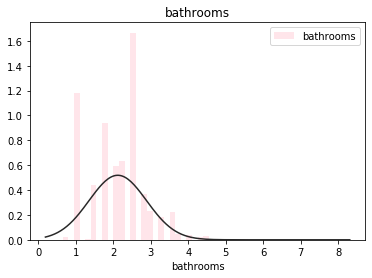

Text(0.5, 1.0, 'sqft_living')

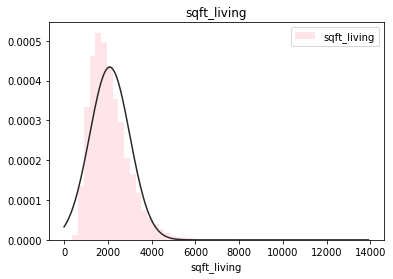

Text(0.5, 1.0, 'sqft_living15')

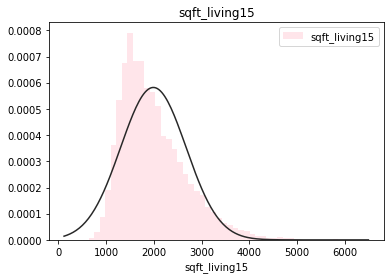

Text(0.5, 1.0, 'sqft_above')

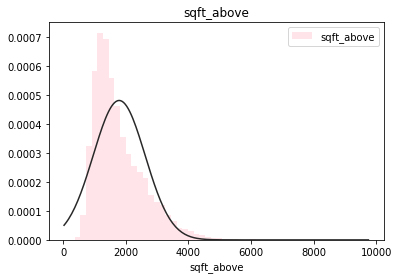

Text(0.5, 1.0, 'grade')

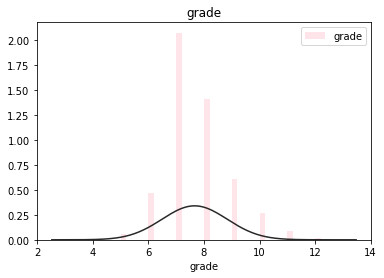

In [9]:
# Create a loop to display all the histograms
for item in data:
    sns.distplot(df[item], color='pink', label=item, fit=norm, kde=False)
    plt.title(item)
    plt.legend()
    plt.show()

All features seem relatively normal except bathrooms. 

## Let's check for any type of correlation

<Figure size 576x432 with 0 Axes>

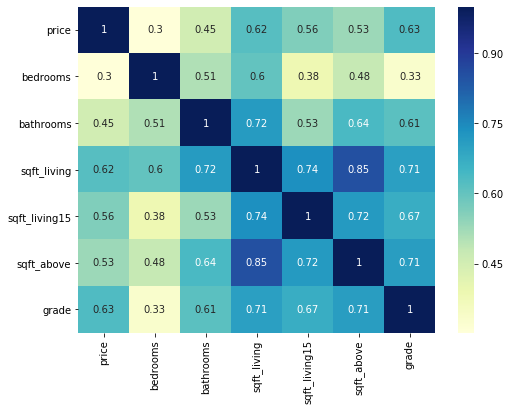

In [10]:
# heatmap to show relationships
plt.figure(figsize=(8,6))
sns.heatmap(data.corr().abs(), annot=True, cmap='YlGnBu')
plt.autoscale()
plt.show()

In [11]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [12]:
X = df_price.drop(columns=['price'])
y = pd.DataFrame(df_price.price, columns= ['price'])

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

/Users/shirlwilliams/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:
X_fin = X[['bedrooms', 'sqft_above', 'sqft_living15', 'grade', 'sqft_living', 'bathrooms']]
X_with_intercept = sm.add_constant(X_fin)
model = sm.OLS(y,X_with_intercept).fit()
model.summary()

The highest correlating factors with price are grade and sqft_living. Here bedrooms also shows a low correlation so I will remove bedrooms as an evaluation feature.

In [ ]:
data = data.drop(['bedrooms'], axis=1)
data.head(2)

## Create an OLS regression model to evaluate features
### Individual Regression Comparisons

In [ ]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
for feature in data:
    d = {}
    formula_str = 'price ~ ' + str(feature)
    res = ols(formula=formula_str, data=data).fit()
    # Make a summary chart
    d['feature'] = feature
    d['intcept'], d['t'] = res.tvalues
    d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
    d['r2'] = res.rsquared
    summaries.append(d)
    res.summary()

In [ ]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df

### Regress Step 2
Using the a stepwise approach. I will select the feature from the first level evaluation with the highest t-value, <b>grade</b>, to continue to evaluate features.

In [ ]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
formula_str = 'price ~ grade + bathrooms'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'bathrooms'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living15'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living15'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_above'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_above'
d['intcept'], d['tg'] , d['tf'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

In [ ]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df.head()

Price with grade and sqft_living have the highest r-squared value, the highest t-value, and the lowest Jarque-Bera

In [ ]:
# Create the OLS model by looping through each feature and create a summary table
summaries = []
formula_str = 'price ~ grade + sqft_living + bathrooms'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'bathrooms'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living + sqft_living15'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_living15'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

formula_str = 'price ~ grade + sqft_living + sqft_above'
d = {}
res = ols(formula=formula_str, data=data).fit()
d['feature'] = 'sqft_above'
d['intcept'], d['tg'] , d['tf1'], d['tf2'] = res.tvalues
d['jb'],d['p'], d['sk'], d['kurt'] = sms.jarque_bera(res.resid)
d['r2'] = res.rsquared
summaries.append(d)
res.summary()

In [ ]:
# Chart comparing specific data values from the OLS Regression above
summaries_df = pd.DataFrame(summaries)
summaries_df.head()

# sqft_living: 
# int -32.318928 tg 52.310300 tf1 48.278051 jb 1424.481869 p 4.760936e-310
# sk 0.602770 kurt 3.483167 r2 0.458443

the higher t-value and r-squared value comes from sqft_above and it is higher than the previous. The Jarque-Bera value is also lower. So I will sqft_above and evaluate it with sqft_living15 and bathrooms. 

In [ ]:
# Create the OLS model by looping through each feature and create a summary table
formula_str = 'price ~ grade + sqft_living + sqft_above + sqft_living15'
res = ols(formula=formula_str, data=data).fit()
res.summary()

# Create the OLS model by looping through each feature and create a summary table
formula_str = 'price ~ grade + sqft_living + sqft_above + bathrooms'
res = ols(formula=formula_str, data=data).fit()
res.summary()

sqft_living15 adds value so I will try all features.

In [ ]:
# Create the OLS model with all features to compare
formula_str = 'price ~ grade + sqft_living + sqft_above + bathrooms + sqft_living15'
res = ols(formula=formula_str, data=data).fit()
res.summary()

Due to the high Condition and Jarque-Bera I suspect we have collinearity. Since grade is actually categorical data I will change it to a category and create dummy variables to properly assess it's predictive value.

## Treating Categorical Data

### Grade
Changing Grade to Categorical Values

In [ ]:
data.grade.describe()

In [ ]:
bins = [0,6,7,8,13]

In [ ]:
bins_grade = pd.cut(data.grade, bins)

In [ ]:
bins_grade = bins_grade.cat.as_ordered()
print(bins_grade)
bins_grade.value_counts().plot(kind='bar')

In [ ]:
# Replace existing 'grade' column
data['grade'] = bins_grade

### Bathrooms

In [ ]:
data.bathrooms.describe()

In [ ]:
bins = [0, 1, 2, 3, 8]

In [ ]:
# Use pd.cut()
bins_bath = pd.cut(data['bathrooms'], bins)
# Using pd.cut() returns unordered categories. Transform this to ordered categories 
bins_bath = bins_bath.cat.as_ordered()
bins_bath.head()

In [ ]:
bins_bath.value_counts().plot(kind='bar')

In [ ]:
data['bathrooms'] = bins_bath

### Perform Label Encoding

In [ ]:
data['grade'] = data['grade'].cat.codes
data['bathrooms'] = data['bathrooms'].cat.codes

In [ ]:
data.head()

### Create Dummy Variables

In [ ]:
grade_dummy = pd.get_dummies(bins_grade, prefix='Grade', drop_first=True)
bath_dummy = pd.get_dummies(bins_bath, prefix='Bath', drop_first=True)

In [ ]:
data = data.drop(['grade', 'bathrooms'], axis=1)

In [ ]:
data.head()

In [ ]:
# Create dummy variables for grade column
data = pd.concat([data, grade_dummy, bath_dummy], axis=1)
data.head()

In [ ]:
grade_dummy

## Feature Ranking with Recursive Feature Elimination

### Stepwise Function

In [ ]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

### Define the Values

In [ ]:
X = data[['sqft_living', 'sqft_living15', 'sqft_above']]
y = data[['price']]

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

In [ ]:
# Select the 5 most important features
linreg = LinearRegression()
selector = RFE(linreg, n_features_to_select = 3)
selector = selector.fit(X, y.values.ravel()) # convert y to 1d np array to prevent DataConversionWarning
selector.support_ 

### Remove sqft_above

In [ ]:
X = data[['sqft_living', 'sqft_living15']]
y = data[['price']]

result = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(result)

### Build the OLS Model

In [ ]:
# Model with new values
formula_str = 'price ~ sqft_living + sqft_living15'
res = ols(formula=formula_str, data=data).fit()
res.summary()

In [ ]:
data.head()

Model with Categorical Values

In [ ]:
# Model with new values
formula_str = 'price ~ sqft_living + sqft_living15'
res = ols(formula=formula_str, data=data).fit()
res.summary()

In [ ]:
plt.figure(figsize=(23, 13))
gfig = sns.boxplot(x="grade", y="price", data=df_price)
plt.title('Grade of Homes by Price')

In [ ]:
# Color coded plot of homes by price and location
df_price.plot(kind='scatter', x='long', y='lat', alpha=0.5, figsize=(8,5), 
        c='price', cmap='rainbow', colorbar=True, sharex=False, edgecolors='gray');
plt.title('Homes by Price')